## Simple figure showing ECE3bis timeseries

Author: Karin van der Wiel, 12-07-2022

In [1]:
## import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## function from L.Muntjewerf (libpyvarex/libtimeseries)
def EUboxmean(da): 
    """
    Author: Laura Muntjewerf, KNMI
    Aim:    Compute spatial weighted mean for Europe
    Input:  xarray DataArray
    Output: xarray DataArray
    """     
    if hasattr(da, 'lat'):
        weights = np.cos(da.lat * np.pi / 180)
        boxmean = da.sel(lat=slice(30,70),lon=slice(-10,40)).weighted(weights).mean(dim=('lat','lon')) 
    elif hasattr(da, 'latitude'):
        weights = np.cos(da.latitude * np.pi / 180)
        boxmean = da.sel(latitude=slice(30,70),longitude=slice(-10,40)).weighted(weights).mean(dim=('latitude','longitude')) 
    return boxmean 

def month_to_season(da,period,agg_type='mean'):
    """
    Author: Karin van der Wiel, KNMI
    Aim:    Compute seasonal means/sums. 
            (Note that DJF is JF...D in a single calendar year)
    """
    # find relevant data, compute mean (if asked for)
    if period == 'ann':
        if agg_type == 'mean':
            # mean (weighted by days in month)
            weights_mon = da.time.dt.days_in_month
            weights_season = weights_mon.groupby(weights_mon.time.dt.year).sum(dim='time')
            da_season = (da*weights_mon).groupby(da.time.dt.year).sum(dim='time') / weights_season
            da_season = da_season.rename({'year':'time'})
        elif agg_type == 'max':
            # max
            da_season = da.groupby(da.time.dt.year).max(dim='time',skipna=True)
            da_season = da_season.rename({'year':'time'})
    elif period in ['DJF','MAM','JJA','SON']:
        if agg_type == 'mean':
            # mean (weighted by days in month)
            weights_mon = da.time.dt.days_in_month
            weights_mon = weights_mon.sel(time=da.time.dt.season==period)
            weights_season = weights_mon.groupby(weights_mon.time.dt.year).sum(dim='time')
            da_sel = da.sel(time=da.time.dt.season==period)
            da_season = (da_sel*weights_mon).groupby(da_sel.time.dt.year).sum(dim='time') / weights_season
            da_season = da_season.rename({'year':'time'})
        elif agg_type == 'max':
            # max
            da_season = da_sel.groupby(da_sel.time.dt.year).max(dim='time')
            da_season = da_season.rename({'year':'time'})
    # attribute book keeping
    da_season.name = da.name
    da_season.attrs = da.attrs
    if agg_type == 'mean':
        da_season.attrs['period'] = f"{period.upper()}-mean"
    elif agg_type == 'max':
        da_season.attrs['period'] = f"{period.upper()}-max"
    return da_season


#### Some figure settings

In [2]:
## figure settings
var = 'tas'
period = 'ann'
ssp = 245

## data
directory = f"/home/kvanderwie/shared_data/volume_2/kkrikken/ECE3bis_Jan2022_fields/orig/"

units = {'tas':'K','pr':'mm'}
colour = 'firebrick'

#### Computation

In [3]:
## open data
ds_hist = xr.open_mfdataset(f"{directory}{var}_mon_ECE3bis_historical_europe.nc")
ds_ssp = xr.open_mfdataset(f"{directory}{var}_mon_ECE3bis_ssp{ssp}_europe.nc")
ds = xr.concat([ds_hist,ds_ssp],dim='time')
del ds_hist, ds_ssp

## region mean
da_eu = EUboxmean(ds[var])

## period mean
da_eu_period = month_to_season(da_eu,period,agg_type='mean')
print(da_eu_period)
da_eu_period.load()

<xarray.DataArray 'tas' (ens: 16, time: 317)>
dask.array<truediv, shape=(16, 317), dtype=float64, chunksize=(16, 1), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2162 2163 2164 2165 2166
Attributes:
    period:   ANN-mean


<xarray.DataArray 'tas' (ens: 16, time: 317)>
array([[284.70846258, 283.83546816, 283.85549957, ..., 289.09169489,
        289.82650848, 289.56527237],
       [283.8873693 , 284.32229566, 284.2168811 , ..., 289.60417119,
        289.70548136, 289.82470122],
       [283.73571827, 284.50935276, 284.53252583, ..., 289.53005175,
        289.59912545, 289.74660523],
       ...,
       [285.12951849, 285.52264704, 284.80766872, ..., 289.65068635,
        289.69436826, 289.82851609],
       [283.88146917, 283.71916111, 283.83908706, ..., 289.06434555,
        289.88884955, 289.3946294 ],
       [283.85505727, 283.72026153, 283.28523812, ..., 289.08343323,
        288.51588864, 288.68404373]])
Coordinates:
    height   float64 2.0
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2162 2163 2164 2165 2166
Attributes:
    period:   ANN-mean

#### Plot figure

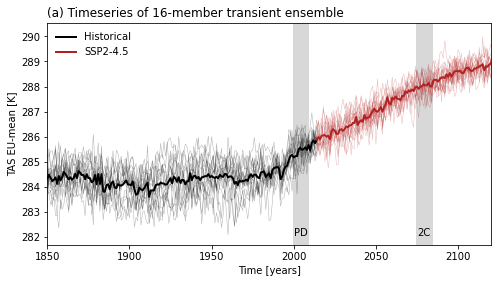

In [6]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
plt.subplots_adjust(left=0.1, bottom=0.13, right=.98, top=0.9)

## data lines
for i_e in da_eu_period.ens:
    plt.plot(range(1850,2015),da_eu_period.sel(ens=i_e).sel(time=slice(1850,2014)),color='black',linewidth=.5,zorder=10,alpha=.3)
    plt.plot(range(2014,2151),da_eu_period.sel(ens=i_e).sel(time=slice(2014,2150)),color=colour,linewidth=.5,zorder=10,alpha=.3)
plt.plot(range(1850,2015),da_eu_period.mean(dim='ens').sel(time=slice(1850,2014)),color='black',linewidth=2,zorder=10,label='Historical')
plt.plot(range(2014,2151),da_eu_period.mean(dim='ens').sel(time=slice(2014,2150)),color=colour,linewidth=2,zorder=10,label=f"SSP{str(ssp)[0]}-{str(ssp)[1]}.{str(ssp)[2]}")

## annotation
ylim = ax.get_ylim()
# LENTIS time slices
plt.fill_between([1999.5,2009.5],np.repeat(ylim[0],2),np.repeat(ylim[1],2),color='grey',alpha=.3,linewidth=0,zorder=0)
plt.fill_between([2074.5,2084.5],np.repeat(ylim[0],2),np.repeat(ylim[1],2),color='grey',alpha=.3,linewidth=0,zorder=0)
plt.text(2004.5,ylim[0]+(ylim[1]-ylim[0])*.04,'PD',fontsize=10,ha='center')
plt.text(2079.5,ylim[0]+(ylim[1]-ylim[0])*.04,'2C',fontsize=10,ha='center')
# text
#plt.text(2010,ylim[1]-(ylim[1]-ylim[0])*.08,'Historical',fontsize=10,ha='right')
#plt.text(2018,ylim[1]-(ylim[1]-ylim[0])*.08,f"SSP{str(ssp)[0]}-{str(ssp)[1]}.{str(ssp)[2]}",fontsize=10,ha='left',color=colour)
plt.legend(loc=2,frameon=False,fontsize=10)
#plt.plot([2014,2014],ylim,color='black',linewidth=.75,linestyle='--',zorder=20)
# labels
plt.ylabel(f"{var.upper()} EU-mean [{units[var]}]")
plt.xlabel(f"Time [years]")
plt.title(f"(a) Timeseries of 16-member transient ensemble",loc='left')
# axes
plt.ylim(ylim[0],ylim[1])
plt.xlim(1850,2120)

plt.savefig(f"fig_ts_{var.upper()}_SSP{ssp}.pdf")
plt.show()